## <font color=Green>GMD Figure 7 </font>  
#### <font color=blue> *Extreme sea-level return-period curve* PLOT </font>


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import netCDF4 as nc
from pandas.plotting import table 
import xarray as xr
#
import warnings
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
#
colrs = 'rcbgmyrkcbgm'

#### <font color=black> *Define* Functions </font>

#### <font color=blue> fn to input </font> <mark> workflow data </mark>

In [3]:
def IP_ncWF(DF,SCENARIO,EXPDATE):
    #
    modNO       = DF.index.values;   # Number of datasets Module outputs
    #
    a = [];     ccomp = []
    #        
    for scenario in SCENARIO:
        for val in modNO:
            WF = DF["Workflow"][val]
            # Skip if data is absent.
            if DF.loc[val].at['Data_File'] == 'XXX':
               continue 
            #   
            # Pick the data files & Import nc file to dataframe. 
            dataFOLDER  = '/projects/kopp/facts-experiments/{arg2}/coupling.{arg1}/output/'.format(arg1=scenario,arg2=EXPDATE)
            dataFILE    = 'coupling.{arg1}.'.format(arg1=scenario) + DF["Data_File"][val]
            d_nc        = xr.open_dataset(dataFOLDER + dataFILE)
            #
            # Index for time.
            ST = 2020 ; EN = 2100
            YindST = np.where(d_nc["years"].values == ST)[0][0];   YindEN = np.where(d_nc["years"].values == EN)[0][0]
            # Save data into a new variable.
            b = d_nc.sea_level_change[:,YindST:YindEN+1,0].values
            a.append(b[None,:] )
    #stack all at once
    SAMPSLOCRISE = np.vstack(a);  SAMPSLOCRISE = np.transpose(SAMPSLOCRISE,(1,2,0))
    yrs=d_nc.years[YindST:YindEN+1].values
    return SAMPSLOCRISE, yrs; 

#### <font color=blue> fn for </font> <mark> GPDLogNExceedances </mark>

In [4]:
def GPDLogNExceedances(z,llambda,shape,scale,MHHW):
    #
    z0 = z
    z = np.maximum(z, 0)  #z[z<0] = 0
    #
    if shape<0:
        z=np.minimum(z,.99999*-scale/shape)
        logN = np.log(llambda*(1+(shape)*z/scale)**(-1/(shape)))
    elif shape==0:
        logN = np.log(llambda)-z/scale
    else:
        logN = np.log(llambda*(1+(shape)*z/scale)**(-1/(shape)))
    #    
    y= logN
    #
    #
    # for those points below threshold to MHHW, put on a Gumbel.
    # if np.max(MHHW.shape)>=1:
    # np.maximum(z0, MHHW(1), z0)
    z0=np.maximum(z0, MHHW) 
    sub = np.argwhere(z0<0)
    #if np.max(MHHW.shape)>=2:
    #    MHHWfreq=MHHW(2); 
    #else:
    MHHWfreq=365.25/2  
    # y(sub) = np.log(llambda)+(np.log(MHHWfreq)-np.log(llambda))*z0(sub)/MHHW(1)
    y[tuple(sub.T)] = np.log(llambda)+(np.log(MHHWfreq)-np.log(llambda))*z0[tuple(sub.T)]/MHHW
    #
    return y    

In [5]:
sitelab='New York';
selectedSite = 12;      #PSMSL ID for NYC
threshold = 0.5148;     #GPD threshold
scale = 0.1285;         #GPD scale
shape = 0.188;          #GPD shape
llambda = 2.8085;        #Poisson Lambda

#### <font color=blue> Load Module data from </font> <mark> facts-experiments </mark>

In [6]:
# Load FACTS module names/data as a dataframe.
df = pd.read_fwf('001_IP_GMD_names_Modules_Data/mod-submod-data_WF_local_Bob_amarel_V2.txt',comment = '#')
df

,Component,Workflow,Data_File
0,total,wf1f,total.workflow.wf1f.local.nc
1,total,wf2f,total.workflow.wf2f.local.nc
2,total,wf3f,total.workflow.wf3f.local.nc
3,total,wf4,total.workflow.wf4.local.nc


In [7]:
EXPDATE     = 221217; SCENARIO    = ['ssp585']
[SAMPSLOCRISE_585, yrs] = IP_ncWF(df,SCENARIO,EXPDATE);
#
EXPDATE     = 221217; SCENARIO    = ['ssp126']
[SAMPSLOCRISE_126, yrs] = IP_ncWF(df,SCENARIO,EXPDATE);
#
#
yrs = np.insert(yrs, 0, 2010, axis=0)
#
testz = np.arange(0, 10+0.01, 0.01)
#
histcurve=np.exp(GPDLogNExceedances(testz-threshold,llambda,shape,scale,-threshold))

In [8]:
def EFcurvWF(PTILE,SAMPSLOCRISE,WFNO,yrs,testz,threshold,llambda,shape,scale):
    #
    workflo  = np.arange(WFNO)
    effcurve = np.empty((yrs.shape[0],testz.shape[0],WFNO,)); effcurve[:] = np.nan
    for wf in workflo: 
        sampslocrise = SAMPSLOCRISE[:,:,wf]
        #
        samps=[];
        samps = np.hstack((np.zeros((sampslocrise.shape[0],1)),sampslocrise)) / 1000
        #
        # samps=np.minimum(samps, np.quantile(samps, .999,axis=0)) #truncate samples viewed as physically implausible
        #
        #
        gg=[]; gg1=[];
        for tt in enumerate(yrs):
            # print(tt[0])
            gg  = testz[np.newaxis] - samps[:,tt[0]][np.newaxis].T
            if PTILE == 'mean': #Find mean
                gg1 = np.real(np.mean(np.exp(GPDLogNExceedances(gg-threshold,llambda,shape,scale,-threshold)),axis=0))
            else:               #Find Percentile
                gg1 = np.real(np.percentile(np.exp(GPDLogNExceedances(gg-threshold,llambda,shape,scale,-threshold)),PTILE,axis=0))
                #
            effcurve[tt[0],:,wf] = np.squeeze(gg1[np.newaxis].T)
            #
    return effcurve
    #


In [9]:
WFNO = 4 # Number of workflows.
effcurve_ssp126_mean = EFcurvWF('mean',SAMPSLOCRISE_126,WFNO,yrs,testz,threshold,llambda,shape,scale)
effcurve_ssp126_50   = EFcurvWF(50,SAMPSLOCRISE_126,WFNO,yrs,testz,threshold,llambda,shape,scale)
effcurve_ssp126_17   = EFcurvWF(17,SAMPSLOCRISE_126,WFNO,yrs,testz,threshold,llambda,shape,scale)
effcurve_ssp126_83   = EFcurvWF(83,SAMPSLOCRISE_126,WFNO,yrs,testz,threshold,llambda,shape,scale)

effcurve_ssp585_mean = EFcurvWF('mean',SAMPSLOCRISE_585,WFNO,yrs,testz,threshold,llambda,shape,scale)
effcurve_ssp585_50   = EFcurvWF(50,SAMPSLOCRISE_585,WFNO,yrs,testz,threshold,llambda,shape,scale)
effcurve_ssp585_17   = EFcurvWF(17,SAMPSLOCRISE_585,WFNO,yrs,testz,threshold,llambda,shape,scale)
effcurve_ssp585_83   = EFcurvWF(83,SAMPSLOCRISE_585,WFNO,yrs,testz,threshold,llambda,shape,scale)

# <font color=green> **PLOT** </font>

In [10]:
WORKFLO = ["wf1f","wf2f","wf3f","wf4"]

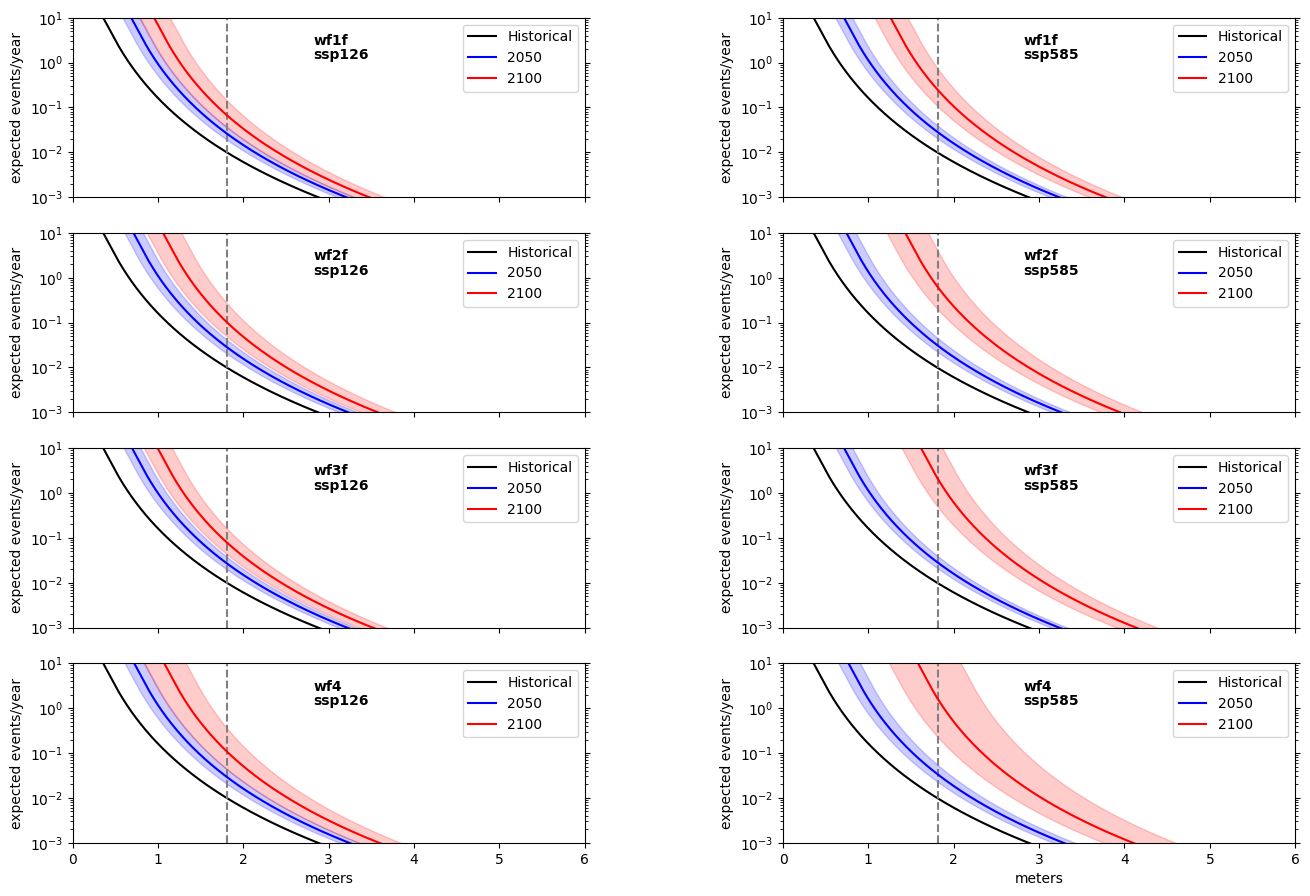

In [29]:
# Set global figure size and dots per inch
plt.rcParams.update({'figure.figsize':(45,30), 'figure.dpi':100})
# Initialize the grid
grid = plt.GridSpec(4, 5, wspace=0.1, hspace=-.4)
grid00 = grid[0].subgridspec(4, 5)
grid01 = grid[1].subgridspec(4, 5)
#
# Axis Spec.
# Global
xlim  = [0,6]
ylim = [1e-3, 10]
#
XAX1 = testz
SSP  = ['ssp126','ssp585']
#
# Subplot Axis.
ax1_wf1f = plt.subplot(grid00[0, :4]); 
ax1_wf2f = plt.subplot(grid00[1, :4]); 
ax1_wf3f = plt.subplot(grid00[2, :4]); 
ax1_wf4  = plt.subplot(grid00[3, :4]); 
#
ax3_wf1f = plt.subplot(grid01[0, :4]);
ax3_wf2f = plt.subplot(grid01[1, :4]);
ax3_wf3f = plt.subplot(grid01[2, :4]);
ax3_wf4  = plt.subplot(grid01[3, :4]); 
#
#
MEASURE='percentile';     # 'mean','percentile'
#
for ss in SSP: # Loop through each SSP
    for wf in enumerate(WORKFLO):
        #
        # Select subplot axis based on workflow
        if ss == 'ssp126': 
            ax1 = eval(f'ax1_{wf[1]}');  
            effcurve   = eval(f'effcurve_{ss}_mean')
            effcurve50 = eval(f'effcurve_{ss}_50')
            effcurve17 = eval(f'effcurve_{ss}_17')
            effcurve83 = eval(f'effcurve_{ss}_83')
            #
        elif ss == 'ssp585':
            ax1 = eval(f'ax3_{wf[1]}');  
            effcurve   = eval(f'effcurve_{ss}_mean')
            effcurve50 = eval(f'effcurve_{ss}_50')
            effcurve17 = eval(f'effcurve_{ss}_17')
            effcurve83 = eval(f'effcurve_{ss}_83')
        yylim = []
        # 
        #
        # Historic.
        ax1.plot(XAX1, histcurve, '-k',label = 'Historical')
        # Grey Line
        # Extract the x-values and y-values from the data
        x = testz; y = histcurve
        # Set a tolerance for the y-values (e.g., 0.1)
        tolerance = 0.01
        # Find the x-values corresponding to y-values that are within the tolerance
        x_intercepts = x[np.abs(y) < tolerance]
        # x_intercepts[0]
        ax1.axvline(x=x_intercepts[0],color=(0.5, 0.5, 0.5),linestyle='--')
        #
        #MEASURE='percentile';     # 'mean','percentile'
        #
        # Plot 2050
        if MEASURE == 'percentile':
            ax1.plot(XAX1, effcurve50[4,:,wf[0]], '-b',label = '2050')
            # ax1.plot(XAX1, effcurve17[4,:,wf[0]], '--b')
            # ax1.plot(XAX1, effcurve83[4,:,wf[0]], '--b')
            ax1.fill_between(XAX1, effcurve17[4,:,wf[0]], effcurve83[4,:,wf[0]],color='blue', alpha=0.2)
        elif MEASURE == 'mean':
            ax1.plot(XAX1, effcurve[4,:,wf[0]], '-b',label = 'N_e (2050)')
        #
        #
        # Plot 2100
        if MEASURE == 'percentile':    
            ax1.plot(XAX1, effcurve50[9,:,wf[0]], '-r',label = '2100')
            # ax1.plot(XAX1, effcurve17[9,:,wf[0]], '--r')
            # ax1.plot(XAX1, effcurve83[9,:,wf[0]], '--r')
            ax1.fill_between(XAX1, effcurve17[9,:,wf[0]], effcurve83[9,:,wf[0]],color='red', alpha=0.2)
        elif MEASURE == 'mean':
            ax1.plot(XAX1, effcurve[9,:,wf[0]], '-r',label = 'N_e (2100)')
        #
        ax1.set_yscale("log")
        #
        ax1.tick_params(axis='both', labelsize=10)
        ax1.yaxis.set_ticks_position('both')
        ax1.legend(loc='upper right',prop={'size': 10}); ax1.set_xlim(xlim); ax1.set_ylim(ylim)
        #
        ax1.set_xlabel("meters");
        ax1.set_ylabel("expected events/year");
         # WorkFlow Title.
        ax1.text(.47, .91, wf[1], horizontalalignment='left',verticalalignment='top',weight='bold',fontsize=10,transform=ax1.transAxes)
        ax1.text(.47, .83, ss, horizontalalignment='left',verticalalignment='top',weight='bold',fontsize=10,transform=ax1.transAxes)
        if wf[1] != 'wf4': ax1.xaxis.set_ticklabels([]); ax1.set_xlabel('')
        # plt.title('NEW YORK') 

    #

In [1]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(testz, y)

# Print the coefficients
print(model.coef_)
print(model.intercept_)

ModuleNotFoundError: No module named 'sklearn'

In [16]:
slope, intercept = np.polyfit(testz, histcurve, 1)
np.roots 

<function numpy.roots(p)>

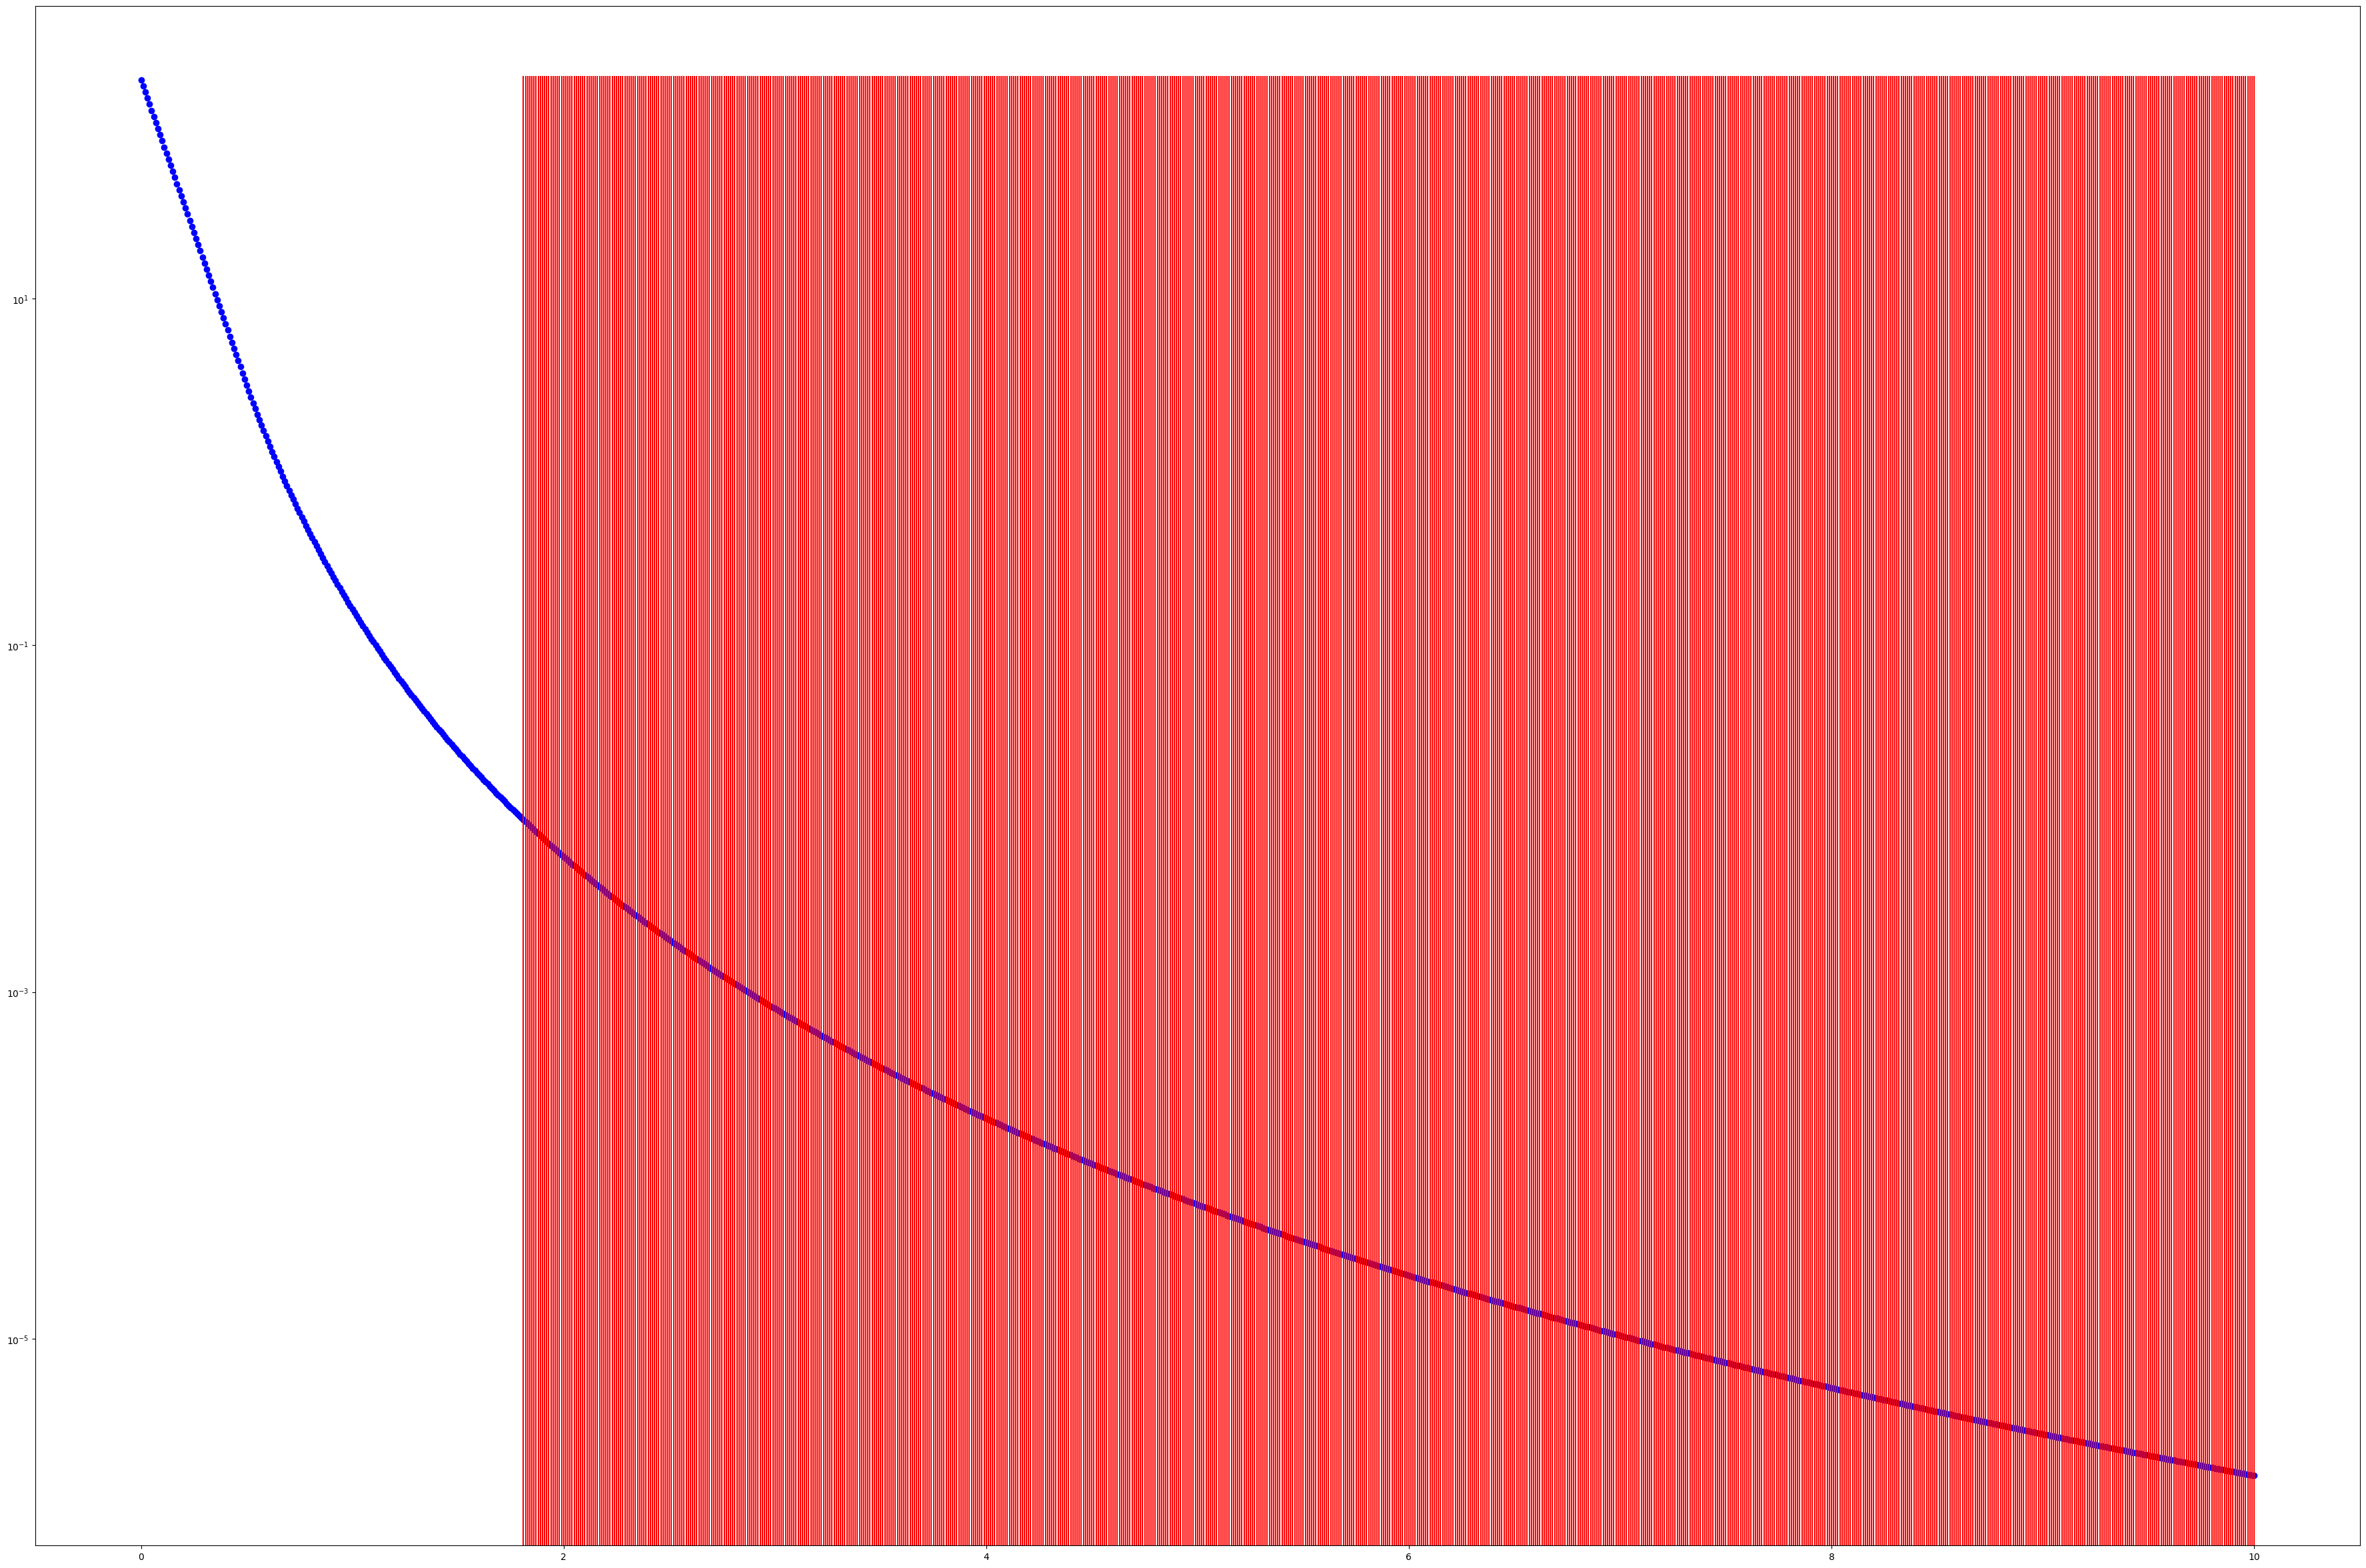

In [25]:
# import matplotlib.pyplot as plt

# Extract the x-values and y-values from the data
x = testz
y = histcurve
# Set a tolerance for the y-values (e.g., 0.1)
tolerance = 0.01
# Find the x-values corresponding to y-values that are within the tolerance
x_intercepts = x[np.abs(y) < tolerance]
x_intercepts[0]

# Plot the data and the x-intercepts
plt.plot(x, y, 'bo')
plt.vlines(x_intercepts, *plt.ylim(), color='r')
plt.yscale("log")
plt.show()

# <font color=black> **=======================================================================** </font>